In [1]:
import torch
import os
import re
import sys
import cv2
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torch import nn
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize

In [2]:
from PoseEstimator.PoseEstimation import model, process_image2, process_output2

In [3]:
torch_device = torch.device('cuda:1')

In [4]:
model_pose = model(pretrained=True)
model_pose = model_pose.to(torch_device)
model_pose.eval() ;

In [250]:
image_path = './sample_image/b1.jpg'
output_path = './output/'

In [251]:
oriImg = cv2.imread(image_path) # B,G,R order

In [252]:
heatmap_avg, paf_avg, segm = process_image2(model_pose, oriImg, torch_device)

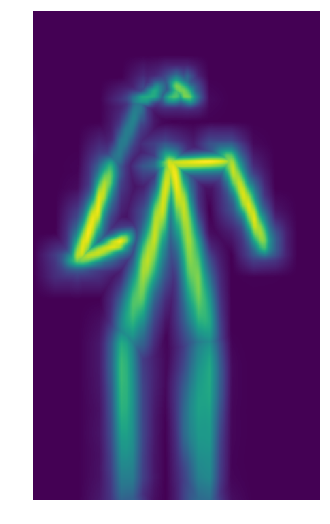

In [253]:
plt.figure(figsize=(9,9))
plt.imshow(paf_avg[:,:,:].max(2))
plt.axis('off')
plt.show()

# Image

In [254]:
def cv2img(img):
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
    return img

In [255]:
img = cv2img(oriImg)

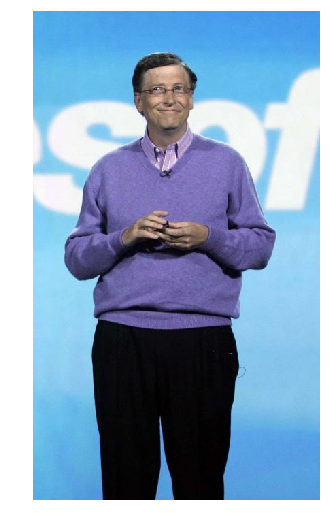

In [256]:
plt.figure(figsize=(9,9))
plt.imshow(img)
plt.axis('off')
plt.show()

## Skeleton

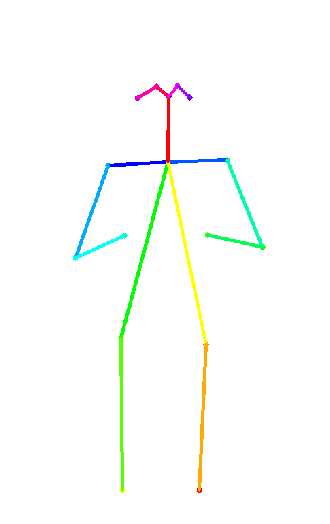

In [257]:
skeleton = process_output2(heatmap_avg, paf_avg, oriImg, skeleton=True)


#skeleton = skeleton.astype(np.uint8)
b,g,r = cv2.split(skeleton)
skeleton = cv2.merge((r,g,b))

skeleton = np.dstack((skeleton, ((skeleton.sum(2)>0)*255)[:,:,None])).astype(np.uint8)
plt.imsave(output_path + 'skeleton.png', skeleton)

plt.figure(figsize=(9,9))
plt.imshow(skeleton)
plt.axis('off')
plt.show()

## Skeleton image

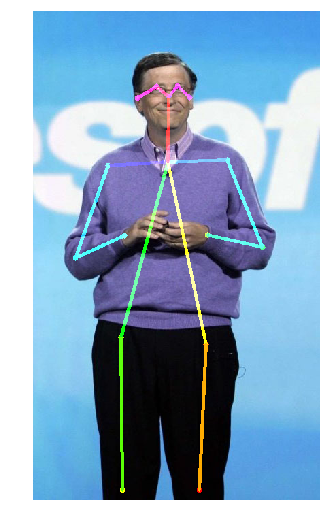

In [258]:
# image skeleton
img_skeleton = cv2.addWeighted(img, 1, skeleton[:,:,:3], 1, 0)
#img_skeleton = cv2.add(img, skeleton[:,:,:3])
plt.imsave(output_path + 'image_skeleton.png', img_skeleton)

plt.figure(figsize=(9,9))
plt.imshow(img_skeleton)
plt.axis('off')
plt.show()

## Segmentation

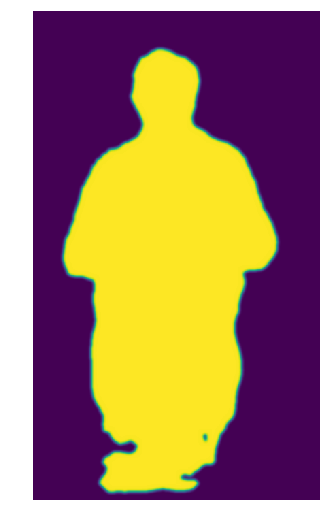

In [270]:
prediction = nn.Upsample((skeleton.shape[0], skeleton.shape[1]), mode='bilinear', align_corners=True)(segm)      
segmentation = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()

segmentation = ((segmentation[:,:,None]>0.5)*255).astype(np.uint8)[:,:,0]
segmentation = gaussian_filter(segmentation, sigma=2)

plt.imsave(output_path + 'segmentation.png', segmentation)


plt.figure(figsize=(9,9))
plt.imshow(segmentation)
plt.axis('off')
plt.show()

## Image segmentation

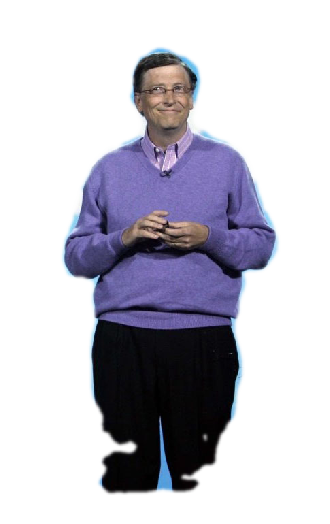

In [271]:
img_segm = np.dstack([img, segmentation])
plt.imsave(output_path + 'image_segmentation.png', img_segm)

plt.figure(figsize=(9,9))
plt.imshow(img_segm)
plt.axis('off')
plt.show()

## Skeleton segmantation

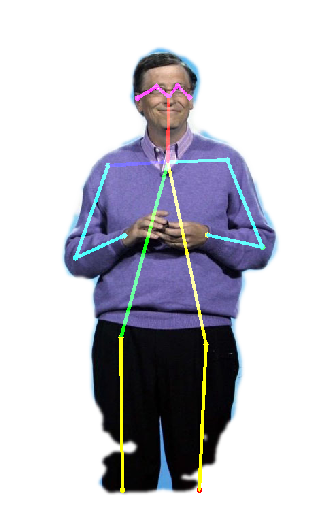

In [272]:
img_skeleton_segm = cv2.addWeighted(img_segm, 1, skeleton, 10, 0)
plt.imsave(output_path + 'image_segmentation_skeleton.png', img_skeleton_segm)

plt.figure(figsize=(9,9))
plt.imshow(img_skeleton_segm)
plt.axis('off')
plt.show()

## Skeleton mask

In [276]:
rgb_mask = cv2.cvtColor(segmentation, cv2.COLOR_GRAY2RGB)
rgb_mask = (rgb_mask > 0.5).astype(np.uint8)
rgb_mask[:,:,0]*= 100
rgb_mask[:,:,1]*= 0
rgb_mask[:,:,2]*= 0
rgb_mask = rgb_mask.astype(np.uint8)
mask_img = cv2.addWeighted(img_skeleton, 1, rgb_mask, 0.7, 0)

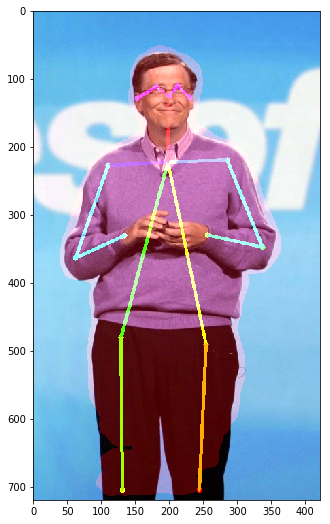

In [277]:
plt.figure(figsize=(9,9))
plt.imshow(mask_img)

## Space

In [278]:
space = plt.imread('./sample_image/space.jpg')
space = resize(space, img.shape[:2])*255
space = space.astype(np.uint8)

/home/e.zholkovskiy/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [279]:
img_space = np.zeros(img.shape,dtype=np.uint8)

alpha_s = img_segm[:, :, 3] / 255.0
alpha_l = 1.0 - alpha_s

for c in range(0, 3):
    img_space[:,:,c] = (alpha_s * img_segm[:,:,c] + alpha_l * space[:,:,c])

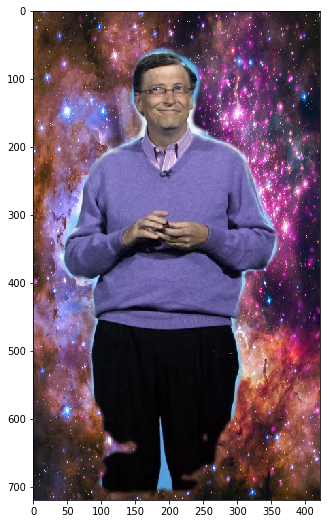

In [280]:
plt.figure(figsize=(9,9))

plt.imshow(img_space)